<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/AnalisisDeDatos/2_Pivot_Table_y_Joins/clase-2.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>
<div align="center"> Recordá abrir en una nueva pestaña </div>


# Pivot tables y joins

## Tabla de Contenidos

    I. Clase 2: Pivot tables y joins
        I. Parámetros y extracción de datos
        II. Pivot table
            I. Contar casos a partir de un registro
            II. Crear un panel a partir de un registro
        III. Concat
        IV. .str
            I. .str.replace()
            II. .str.split()
        V. .map
        VI. Merge

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

plt.style.use('ggplot')
%matplotlib inline

/var/folders/ph/5sq6jlj161g1_2t838crnx6c0000gp/T/ipykernel_2022/2212339234.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Parámetros y extracción de datos

In [3]:
# input
# CASOS_URL = "https://sisa.msal.gov.ar/datos/descargas/covid-19/files/Covid19Casos.csv" no funciona
# DETERMINACIONES_URL = "https://sisa.msal.gov.ar/datos/descargas/covid-19/files/Covid19Determinaciones.csv" no funciona

CASOS_URL = "./covid_casos.csv"

CASOS_PATH = "./data/covid_casos.csv"
# DETERMINACIONES_PATH = "./data/covid_determinaciones.csv"

# output
PANEL_CASOS_PATH = "./data/covid19-casos-panel.csv"

Si los sacamos de internet, podemos usar directamente la URL de cualquier CSV. Siempre es buena práctica guardar una copia por si en algún momento una URL deja de estar disponible.

In [5]:
converters = {
    "residencia_provincia_id": lambda x: str(x).zfill(2),
    "departamento_provincia_id": lambda x: str(x).zfill(3),
    "codigo_indec_provincia": lambda x: str(x).zfill(2),
    "codigo_indec_departamento": lambda x: str(x).zfill(3),
}

# lee la copia de Internet (si funcionara)
# casos = pd.read_csv(CASOS_URL, converters=converters, nrows=1000000)
# determinaciones = pd.read_csv(DETERMINACIONES_URL, converters=converters)

# guarda los datos localmente
# casos.to_csv(CASOS_PATH, encoding="utf8", index=False)
#determinaciones.to_csv(DETERMINACIONES_PATH, encoding="utf8", index=False)

# lee la copia local
casos = pd.read_csv(CASOS_PATH, converters=converters)
#determinaciones = pd.read_csv(DETERMINACIONES_PATH, converters=converters)

In [7]:
casos.shape

(500000, 25)

In [6]:
casos.head()

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,1000000,M,55.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,02,2020-06-09,0,2022-06-05
1,10000000,F,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,02,2021-04-08,0,2022-06-05
2,10000001,F,23.0,Años,Argentina,Buenos Aires,Lomas de Zamora,Buenos Aires,2021-04-05,2021-04-08,...,NaN,NO,6,Público,Caso Descartado,Descartado,06,2021-04-08,490,2022-06-05
3,10000002,F,45.0,Años,Argentina,Buenos Aires,La Matanza,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,06,2021-04-06,427,2022-06-05
4,10000003,F,34.0,Años,Argentina,CABA,COMUNA 01,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,02,2021-04-08,1,2022-06-05


## Pivot table

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

La función de `DataFrame.pivot_table` permite crear una tabla dinámica (de la misma forma que se podría hacer en una planilla de cálculo como Excel) fácilmente, eligiendo qué columnas se quieren mostrar en:

* **índice (index)**: lo que se usa para abrir los datos en filas.
* **columnas (columns)**: lo que se usa para abrir los datos en columnas.
* **valores (values)**: las variables que se quieren abrir en filas y columnas (las celdas con el contenido).

Y se puede elegir una o más funciones de agregación para aplicar a los valores cuando son agregados.

### Contar casos a partir de un registro

**Casos**

En el dataset de **casos** nos enfrentamos a un **registro**: el dataset es una lista de casos, donde cada fila es un "caso". No tenemos columnas con variables agregadas (esto es, cálculos extras sobre los datos como sumas, maximos, minismo, etc, aquí no hay nada de eso), tenemos la materia prima sobre la cual se construyen las estadísticas o las agregaciones de cualquier tipo.

Las tablas dinámicas son una buena forma de agregar! En este caso la primera agregación obvia es _contar casos_. Tratemos de **contar la cantidad de casos de Covid por provincia**. 

In [5]:
casos.columns

Index(['id_evento_caso', 'sexo', 'edad', 'edad_años_meses',
       'residencia_pais_nombre', 'residencia_provincia_nombre',
       'residencia_departamento_nombre', 'carga_provincia_nombre',
       'fecha_inicio_sintomas', 'fecha_apertura', 'sepi_apertura',
       'fecha_internacion', 'cuidado_intensivo', 'fecha_cui_intensivo',
       'fallecido', 'fecha_fallecimiento', 'asistencia_respiratoria_mecanica',
       'carga_provincia_id', 'origen_financiamiento', 'clasificacion',
       'clasificacion_resumen', 'residencia_provincia_id', 'fecha_diagnostico',
       'residencia_departamento_id', 'ultima_actualizacion'],
      dtype='object')

In [6]:
# busquemos las columnas que vamos a necesitar usar primero
casos.head()

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,1000000,M,55.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,02,2020-06-09,0,2022-06-05
1,10000000,F,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,02,2021-04-08,0,2022-06-05
2,10000001,F,23.0,Años,Argentina,Buenos Aires,Lomas de Zamora,Buenos Aires,2021-04-05,2021-04-08,...,NaN,NO,6,Público,Caso Descartado,Descartado,06,2021-04-08,490,2022-06-05
3,10000002,F,45.0,Años,Argentina,Buenos Aires,La Matanza,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,06,2021-04-06,427,2022-06-05
4,10000003,F,34.0,Años,Argentina,CABA,COMUNA 01,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,02,2021-04-08,1,2022-06-05


In [7]:
casos.shape

(1000000, 25)

In [8]:
casos["residencia_provincia_nombre"].unique() # devuelve un array de numpy con los valores de una columna, sin repetir

array(['CABA', 'Buenos Aires', 'Santa Fe', 'Entre Ríos',
       'Tierra del Fuego', 'Córdoba', 'San Luis', 'Río Negro', 'Mendoza',
       'Santa Cruz', 'Corrientes', 'La Pampa', 'SIN ESPECIFICAR', 'Chaco',
       'Formosa', 'Salta', 'Neuquén', 'Misiones', 'Santiago del Estero',
       'Tucumán', 'Chubut', 'San Juan', 'Catamarca', 'La Rioja', 'Jujuy'],
      dtype=object)

In [9]:
casos["residencia_provincia_nombre"].value_counts() # suma los casos confirmados y descartados de cada provincia

residencia_provincia_nombre
Buenos Aires           399570
CABA                   180249
Córdoba                103430
Santa Fe                53514
Mendoza                 34780
Tucumán                 33996
San Luis                33032
Corrientes              17519
Chaco                   16953
Entre Ríos              13207
San Juan                12655
Salta                   10688
La Pampa                 9887
Santiago del Estero      9428
Santa Cruz               8954
Formosa                  8750
Río Negro                8611
Chubut                   8431
Neuquén                  7284
Catamarca                7272
Jujuy                    6435
La Rioja                 5035
Misiones                 4287
Tierra del Fuego         3724
SIN ESPECIFICAR          2309
Name: count, dtype: int64

In [10]:
for col in casos.columns:
    if col.startswith("fecha"):
        print(col)

fecha_inicio_sintomas
fecha_apertura
fecha_internacion
fecha_cui_intensivo
fecha_fallecimiento
fecha_diagnostico


In [11]:
casos["clasificacion_resumen"].value_counts()

clasificacion_resumen
Descartado    614776
Confirmado    352883
Sospechoso     32341
Name: count, dtype: int64

In [31]:
casos["clasificacion_resumen"]

0         Descartado
1         Descartado
2         Descartado
3         Descartado
4         Descartado
             ...    
999995    Descartado
999996    Descartado
999997    Confirmado
999998    Confirmado
999999    Descartado
Name: clasificacion_resumen, Length: 1000000, dtype: object

In [12]:
casos[casos["clasificacion_resumen"] == "Confirmado"].head()

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
16,10000015,F,49.0,Años,Argentina,Entre Ríos,Nogoyá,Entre Ríos,2021-04-03,2021-04-08,...,NaN,NO,30,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,30,2021-04-08,77,2022-06-05
27,10000026,F,24.0,Años,Argentina,Córdoba,Capital,Córdoba,2021-04-03,2021-04-08,...,NaN,NO,14,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,14,2021-04-05,14,2022-06-05
51,10000049,F,74.0,Años,Argentina,CABA,COMUNA 09,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,02,2021-04-10,9,2022-06-05
58,10000055,F,43.0,Años,Argentina,CABA,COMUNA 09,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,02,2021-04-14,9,2022-06-05
60,10000057,M,36.0,Años,Argentina,Buenos Aires,Mercedes,Buenos Aires,NaN,2021-04-08,...,NaN,NO,6,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,06,2021-04-06,532,2022-06-05


In [13]:
casos.clasificacion_resumen == "Confirmado"

0         False
1         False
2         False
3         False
4         False
          ...  
999995    False
999996    False
999997     True
999998     True
999999    False
Name: clasificacion_resumen, Length: 1000000, dtype: bool

La función pivot_table básicamente nos devuelve una nueva tabla filtrada, en donde establecemos con el parámetro "index" qué columna se tomarán como filas, toma los valores de las celdas de esa columna, sin repeticiones, y las coluca una debajo de la otra, como fi fueran justamente índices de esta nueva tabla. Por otro lado, se puede establecer qué columna/s queremos ver, y finalmente qué veremos en las celdas con el parámetro "values", añadiendo o no funciones de agregación como en el caso de abajo.

In [14]:
casos["id_evento_caso"]

0          1000000
1         10000000
2         10000001
3         10000002
4         10000003
            ...   
999995    10964856
999996    10964857
999997    10964858
999998    10964859
999999     1096486
Name: id_evento_caso, Length: 1000000, dtype: int64

In [15]:
casos_provincias = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=["residencia_provincia_nombre"],
    values=["id_evento_caso"],
    aggfunc="count"
)
casos_provincias.sort_values("id_evento_caso", ascending=False)

,id_evento_caso
residencia_provincia_nombre,
Buenos Aires,175354
CABA,48388
Córdoba,23888
Santa Fe,22173
San Luis,14338
Mendoza,12585
Tucumán,9333
Entre Ríos,6576
Chaco,3775


Primer reflejo que siempre tenés que tener: controlar el resultado con algún parámetro conocido (en lo posible). En este caso, tratemos de ver si la suma de casos tiene sentido o no asi como quedo hecha con el pivot_table

In [16]:
# esto seria similar a algo como este filtro:
verificacion = casos.query("clasificacion_resumen == 'Confirmado'")["residencia_provincia_nombre"].value_counts()
verificacion

residencia_provincia_nombre
Buenos Aires           175354
CABA                    48388
Córdoba                 23888
Santa Fe                22173
San Luis                14338
Mendoza                 12585
Tucumán                  9333
Entre Ríos               6576
Chaco                    3775
Corrientes               3525
Río Negro                3200
San Juan                 3082
La Pampa                 3073
Santiago del Estero      2937
Salta                    2878
Santa Cruz               2615
Neuquén                  2607
Chubut                   2532
Catamarca                2454
Misiones                 1816
La Rioja                 1386
Jujuy                    1247
Tierra del Fuego         1227
Formosa                  1180
SIN ESPECIFICAR           714
Name: count, dtype: int64

In [17]:
casos_provincias.id_evento_caso.sum()

352883

En Google se muestra siempre el último dato reportado a la OMS, es un buen control

https://www.google.com/search?q=casos+coronavirus+argentina&oq=casos+coronavirus&aqs=chrome.1.69i57j0l6j69i60.3332j0j7&sourceid=chrome&ie=UTF-8

**Ejercicio:** crear una tabla contando la cantidad de casos fallecidos y controlarla. Pista: tenés que agregar un filtro más a la tabla anterior, que use la columna "fecha_fallecimiento".

In [18]:
casos[casos.fecha_fallecimiento.notna()].head(3)

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
83,10000079,M,55.0,Años,Argentina,Buenos Aires,Quilmes,Buenos Aires,2021-04-08,2021-04-08,...,2021-04-23,NO,6,Privado,Caso confirmado por laboratorio - Fallecido,Confirmado,06,2021-04-10,658,2022-06-05
89,10000084,M,47.0,Años,Argentina,Buenos Aires,Ituzaingó,Buenos Aires,2021-04-04,2021-04-08,...,2021-04-24,NO,6,Público,Caso confirmado por laboratorio - Fallecido,Confirmado,06,2021-04-09,410,2022-06-05
643,10000608,F,52.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,NaN,2021-04-08,...,2021-05-08,NO,2,Público,Caso confirmado por laboratorio - Fallecido,Confirmado,02,2021-04-21,0,2022-06-05


In [19]:
casos_fallecidos_provincias = casos.query("clasificacion_resumen == 'Confirmado' & fecha_fallecimiento.notna()").pivot_table(
    index=["residencia_provincia_nombre"],
    values=["id_evento_caso"],
    aggfunc="count"
)
casos_fallecidos_provincias.sort_values("id_evento_caso", ascending=False)

,id_evento_caso
residencia_provincia_nombre,
Buenos Aires,4418
CABA,1044
Santa Fe,388
Mendoza,294
Córdoba,247
San Luis,133
Tucumán,125
Chaco,84
Entre Ríos,72


In [20]:
verificacion_fallecidos = casos.query("clasificacion_resumen == 'Confirmado' & fecha_fallecimiento.notna()")["residencia_provincia_nombre"].value_counts()
verificacion_fallecidos

residencia_provincia_nombre
Buenos Aires           4418
CABA                   1044
Santa Fe                388
Mendoza                 294
Córdoba                 247
San Luis                133
Tucumán                 125
Chaco                    84
Entre Ríos               72
Corrientes               71
Río Negro                66
Chubut                   57
Neuquén                  53
San Juan                 50
La Pampa                 49
La Rioja                 45
Santa Cruz               43
Salta                    42
Catamarca                41
Santiago del Estero      37
Formosa                  34
Jujuy                    27
Misiones                 24
Tierra del Fuego         13
SIN ESPECIFICAR           3
Name: count, dtype: int64

### Crear un panel a partir de un registro

Una estructura muy común de dataset de **panel** tiene:

* 1 o más variables (generalmente numéricas)
* 1 dimensión de apertura temporal
* 1 o más dimensiones de apertura _no temporales_

Convertir registros en paneles, es un paso lógico en el procesamiento de datos primarios hacia la construcción de productos estadísticos o analíticos. Encapsula una parte del esfuerzo que conviene hacer bien de una sola vez, y luego utilizar el panel fácilmente para la mayoría de nuestras necesidades. 

En este caso vamos a elegir cuáles son nuestras variables de interés para **construir el panel de casos de Covid**:

* provincia
* sexo
* fecha (tiene que haber una dimensión temporal)

In [21]:
# Ya nos queda esta tabla dinamica como una nueva tabla/dataframe a utilziar para proximas actividades y analisis
casos_panel = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_diagnostico"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
print(type(casos_panel))
casos_panel

<class 'pandas.core.frame.DataFrame'>


,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_diagnostico,id_evento_caso
0,02,CABA,F,2020-05-05,1
1,02,CABA,F,2020-05-27,1
2,02,CABA,F,2020-05-29,2
3,02,CABA,F,2020-05-30,3
4,02,CABA,F,2020-05-31,7
...,...,...,...,...,...
6258,99,SIN ESPECIFICAR,M,2022-01-06,1
6259,99,SIN ESPECIFICAR,M,2022-01-19,1
6260,99,SIN ESPECIFICAR,NR,2020-06-08,1
6261,99,SIN ESPECIFICAR,NR,2020-06-09,1


Ahora realizar distintos gráficos es muy fácil! Sólo hay que hacer una tabla dinámica sobre nuestro panel eligiendo las variables.

In [22]:
casos_evolucion_genero = casos_panel.pivot_table(
    columns="sexo",
    index="fecha_diagnostico",
    values="id_evento_caso",
    aggfunc="sum"
)
casos_evolucion_genero

sexo,F,M,NR
fecha_diagnostico,,,
2020-01-02,1.0,NaN,NaN
2020-01-18,NaN,1.0,NaN
2020-03-19,1.0,NaN,NaN
2020-04-27,NaN,1.0,NaN
2020-04-29,NaN,1.0,NaN
...,...,...,...
2022-03-03,NaN,2.0,NaN
2022-03-04,1.0,1.0,NaN
2022-03-05,2.0,1.0,NaN


<Axes: xlabel='fecha_diagnostico'>

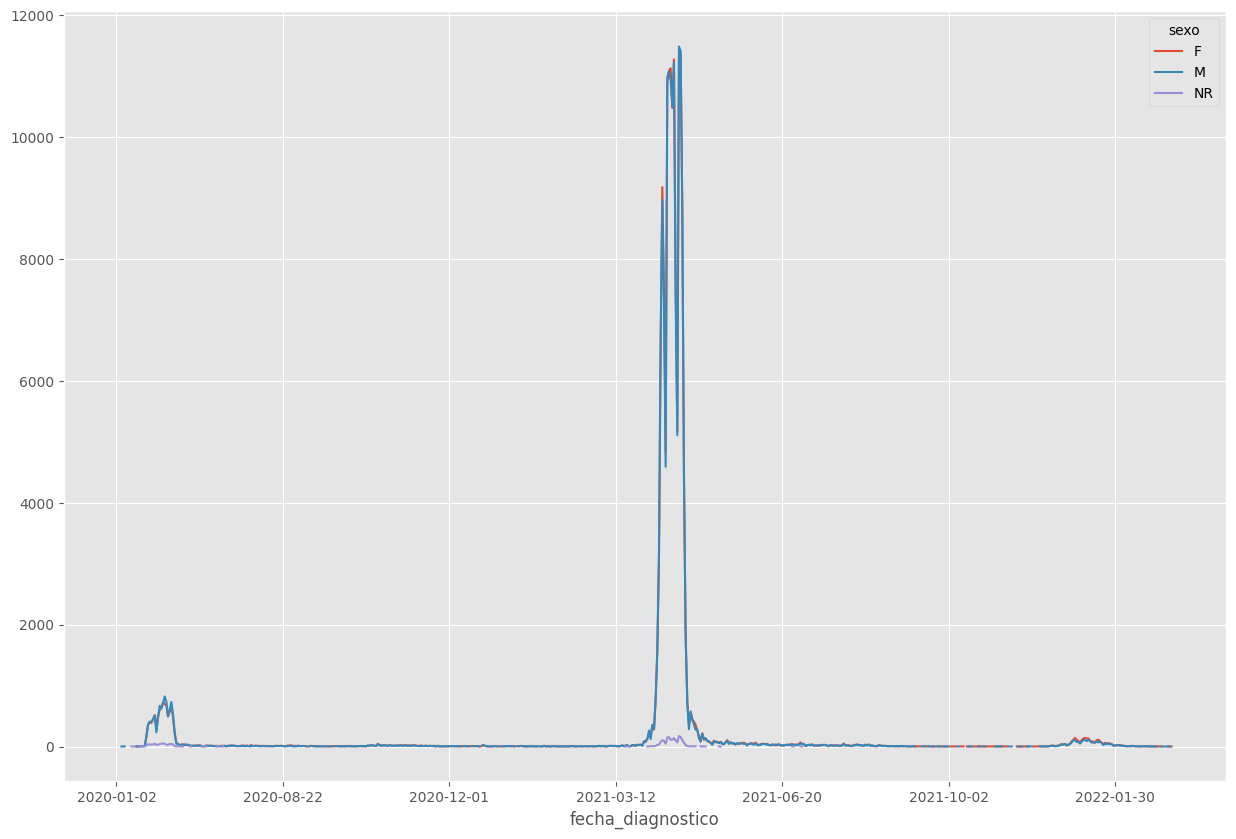

In [23]:
casos_evolucion_genero.plot(figsize=(15, 10))

**Ejercicio:** graficar la evolución de casos por provincia.

In [24]:
casos_evolucion_provincia = casos_panel.pivot_table(
    columns="residencia_provincia_nombre",
    index="fecha_diagnostico",
    values="id_evento_caso",
    aggfunc="sum"
)
casos_evolucion_provincia

residencia_provincia_nombre,Buenos Aires,CABA,Catamarca,Chaco,Chubut,Corrientes,Córdoba,Entre Ríos,Formosa,Jujuy,...,Río Negro,SIN ESPECIFICAR,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán
fecha_diagnostico,,,,,,,,,,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2020-01-18,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-27,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2022-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2022-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='fecha_diagnostico'>

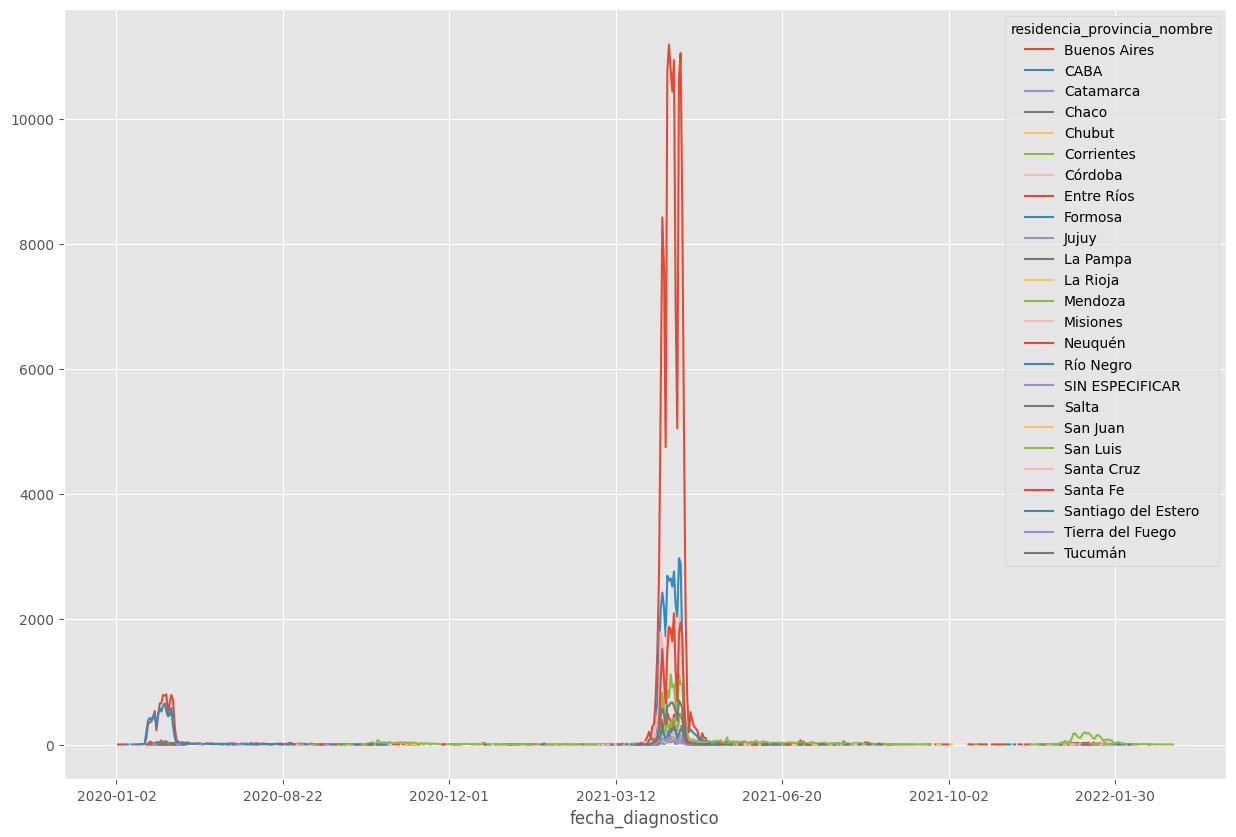

In [25]:
casos_evolucion_provincia.plot(figsize=(15, 10))

## Concat 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html

Pero ahora queremos graficar las curvas de casos confirmados y fallecidos, y nos damos cuenta de que a nuestro panel construido para trabajar le falta una nueva dimensión de apertura de la variable **casos**: el **estado** del caso.

Tenemos que agregar la variable **estado** a nuestro panel, con por lo menos dos estados: **confirmados** y **fallecios**. Para esto vamos a construir paneles **idénticos** para cada una de las variables y concatenarlos.

In [26]:
casos_panel_confirmados = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_diagnostico"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
casos_panel_confirmados.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_diagnostico,id_evento_caso
0,02,CABA,F,2020-05-05,1
1,02,CABA,F,2020-05-27,1
2,02,CABA,F,2020-05-29,2
3,02,CABA,F,2020-05-30,3
4,02,CABA,F,2020-05-31,7


Ahora armemos el panel de casos fallecidos con la misma estructura.

In [27]:
casos_panel_fallecidos = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_fallecimiento"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
casos_panel_fallecidos.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_fallecimiento,id_evento_caso
0,02,CABA,F,2020-06-02,2
1,02,CABA,F,2020-06-03,1
2,02,CABA,F,2020-06-04,1
3,02,CABA,F,2020-06-07,2
4,02,CABA,F,2020-06-08,5


Y ahora necesitamos modificar ambos paneles para que tengan la misma estructura, y así poder concatenarlos.

* Agregar una columna para la dimensión "estado"
* Renombrar las columnas para que sigan teniendo sentido cuando sumemos información

In [28]:
casos_panel_confirmados["estado"] = "confirmados"
casos_panel_confirmados = casos_panel_confirmados.rename(columns={
    "fecha_diagnostico": "fecha",
    "id_evento_caso": "casos"
})
casos_panel_confirmados.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-05-05,1,confirmados
1,02,CABA,F,2020-05-27,1,confirmados
2,02,CABA,F,2020-05-29,2,confirmados
3,02,CABA,F,2020-05-30,3,confirmados
4,02,CABA,F,2020-05-31,7,confirmados


In [29]:
casos_panel_fallecidos["estado"] = "fallecidos"
casos_panel_fallecidos = casos_panel_fallecidos.rename(columns={
    "fecha_fallecimiento": "fecha",
    "id_evento_caso": "casos"
})
casos_panel_fallecidos.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-06-02,2,fallecidos
1,02,CABA,F,2020-06-03,1,fallecidos
2,02,CABA,F,2020-06-04,1,fallecidos
3,02,CABA,F,2020-06-07,2,fallecidos
4,02,CABA,F,2020-06-08,5,fallecidos


Y ahora el momento de la verdad! Generemos un solo panel con todos los datos. La funcion concat() lo que hace es concatener dataframes, es decir, colocar uno debajo del otro. Para ello, la condicion es que tengan las mismas columnas que represente la misma información, justamente para que tengan sentido al concatenarlas.

In [31]:
casos_panel2 = pd.concat([casos_panel_confirmados, casos_panel_fallecidos])
casos_panel2

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-05-05,1,confirmados
1,02,CABA,F,2020-05-27,1,confirmados
2,02,CABA,F,2020-05-29,2,confirmados
3,02,CABA,F,2020-05-30,3,confirmados
4,02,CABA,F,2020-05-31,7,confirmados
...,...,...,...,...,...,...
1668,94,Tierra del Fuego,M,2021-04-29,1,fallecidos
1669,94,Tierra del Fuego,M,2021-05-08,1,fallecidos
1670,99,SIN ESPECIFICAR,F,2021-04-18,1,fallecidos
1671,99,SIN ESPECIFICAR,F,2021-04-24,1,fallecidos


Ya podemos graficar fallecidos

In [32]:
casos_evolucion_genero2 = casos_panel2[
    casos_panel2.estado == "fallecidos"
].pivot_table(
    columns="sexo",
    index="fecha",
    values="casos",
    aggfunc="sum"
)
casos_evolucion_genero2

sexo,F,M,NR
fecha,,,
2020-05-31,NaN,1.0,NaN
2020-06-01,1.0,1.0,NaN
2020-06-02,3.0,2.0,2.0
2020-06-03,1.0,7.0,1.0
2020-06-04,5.0,5.0,NaN
...,...,...,...
2021-09-14,NaN,1.0,NaN
2021-09-26,NaN,1.0,NaN
2021-12-12,1.0,NaN,NaN


<Axes: xlabel='fecha'>

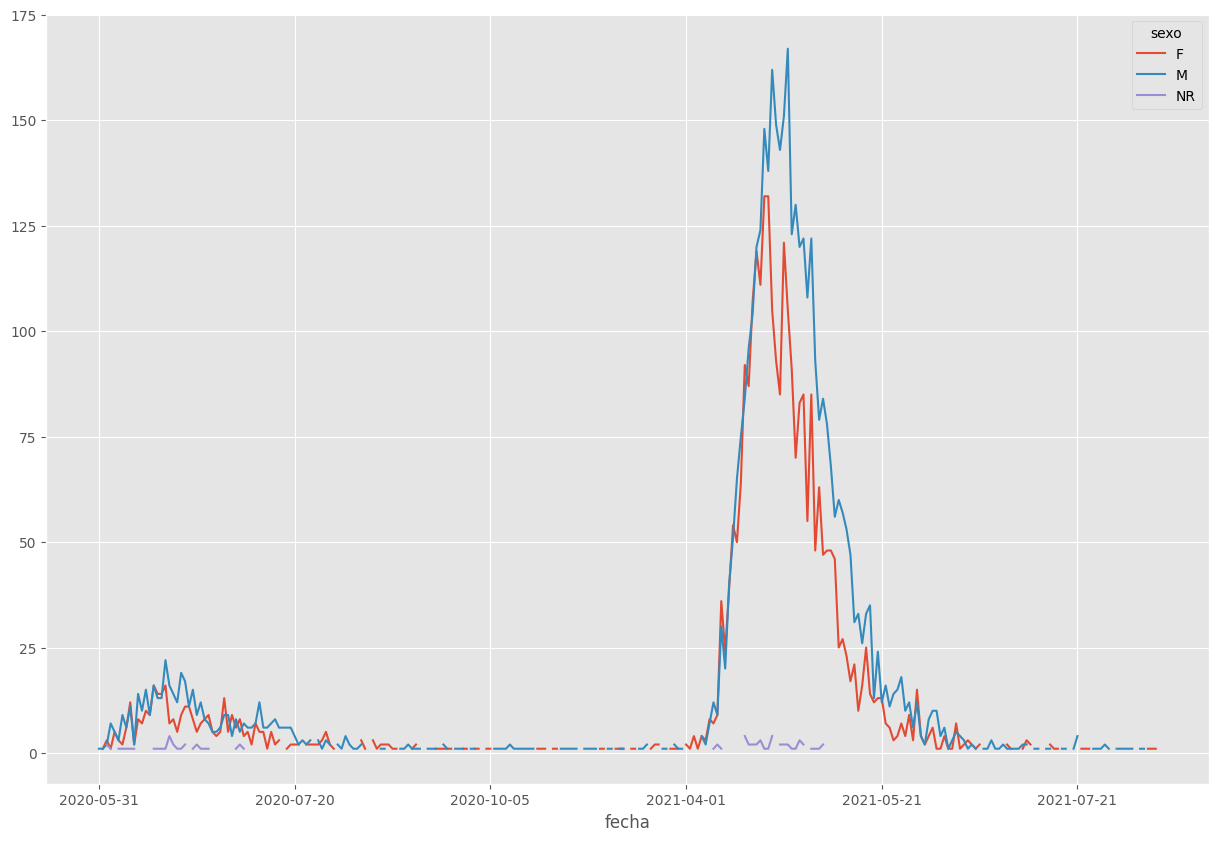

In [33]:
casos_evolucion_genero2.plot(figsize=(15,10))

**Ejercicio:** crear el panel `casos_panel_descartados` y concatenarlo a los otros dos generando un `casos_panel3`.

In [35]:
casos.head(3)

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,1000000,M,55.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,02,2020-06-09,0,2022-06-05
1,10000000,F,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,02,2021-04-08,0,2022-06-05
2,10000001,F,23.0,Años,Argentina,Buenos Aires,Lomas de Zamora,Buenos Aires,2021-04-05,2021-04-08,...,NaN,NO,6,Público,Caso Descartado,Descartado,06,2021-04-08,490,2022-06-05


In [37]:
casos_panel_descartados = casos.query("clasificacion_resumen == 'Descartado'").pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_inicio_sintomas"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
casos_panel_descartados.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_inicio_sintomas,id_evento_caso
0,02,CABA,F,2020-02-11,1
1,02,CABA,F,2020-02-14,1
2,02,CABA,F,2020-02-26,1
3,02,CABA,F,2020-03-23,2
4,02,CABA,F,2020-04-01,1


In [39]:
casos_panel_descartados["estado"] = "Descartados"
casos_panel_descartados = casos_panel_descartados.rename(
    columns={
        "fecha_inicio_sintomas": "fecha",
        "id_evento_caso": "casos"
    }
)
casos_panel_descartados.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-02-11,1,Descartados
1,02,CABA,F,2020-02-14,1,Descartados
2,02,CABA,F,2020-02-26,1,Descartados
3,02,CABA,F,2020-03-23,2,Descartados
4,02,CABA,F,2020-04-01,1,Descartados


In [71]:
casos_panel3 = pd.concat([casos_panel_confirmados, casos_panel_fallecidos, casos_panel_descartados])
casos_panel3

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-05-05,1,confirmados
1,02,CABA,F,2020-05-27,1,confirmados
2,02,CABA,F,2020-05-29,2,confirmados
3,02,CABA,F,2020-05-30,3,confirmados
4,02,CABA,F,2020-05-31,7,confirmados
...,...,...,...,...,...,...
4270,99,SIN ESPECIFICAR,NR,2020-06-09,1,Descartados
4271,99,SIN ESPECIFICAR,NR,2020-06-10,1,Descartados
4272,99,SIN ESPECIFICAR,NR,2021-04-12,1,Descartados
4273,99,SIN ESPECIFICAR,NR,2021-04-14,1,Descartados


## .str

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.html

Todas las columnas (Series) de un data frame tienen diferentes métodos asociados que se pueden utilzar para hacer transformaciones rápidamente.

Hay un grupo de ellos accesible a través del atributo `str` (`Series.str`) que implementa las funciones usuales de Python sobre strings, para una columna de valores de texto.

### .str.replace() 

Si queremos graficar la evolución de casos por sexo, pero queremos una leyenda con la palabra completa, tal vez necesitemos reemplazar los valores usados en el dataset por otros.

In [41]:
casos_panel2.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-05-05,1,confirmados
1,02,CABA,F,2020-05-27,1,confirmados
2,02,CABA,F,2020-05-29,2,confirmados
3,02,CABA,F,2020-05-30,3,confirmados
4,02,CABA,F,2020-05-31,7,confirmados


In [42]:
casos_panel2["sexo"] = casos_panel2.sexo.str.replace(
    "F", "Femenino"
).replace(
    "M", "Masculino"
).replace(
    "NR", "No responde"
)

In [43]:
casos_panel2.sexo.value_counts()

sexo
Masculino      3819
Femenino       3691
No responde     426
Name: count, dtype: int64

**Ejercicio:** modificar la columna `residencia_provincia_nombre` reemplazando "CABA" por "Ciudad Autónoma de Buenos Aires".

In [44]:
casos_panel2["residencia_provincia_nombre"] = casos_panel2["residencia_provincia_nombre"].str.replace(
    "CABA", "Ciudad Autónoma de Buenos Aires"
)

In [45]:
casos_panel2["residencia_provincia_nombre"].value_counts()

residencia_provincia_nombre
Buenos Aires                       1372
Ciudad Autónoma de Buenos Aires     942
San Luis                            820
Córdoba                             439
Mendoza                             348
La Rioja                            330
Catamarca                           320
Santa Fe                            301
Tucumán                             295
Río Negro                           278
Chaco                               233
Chubut                              222
San Juan                            216
Salta                               210
Neuquén                             191
Jujuy                               189
Corrientes                          186
La Pampa                            184
Santiago del Estero                 168
Entre Ríos                          166
Santa Cruz                          165
SIN ESPECIFICAR                     109
Formosa                             102
Misiones                             75
Tierra del F

###  .str.split()

Si queremos agrupar por mes, tal vez necesitamos partir la fecha en tres partes.

In [46]:
casos_panel2.fecha.str.split("-")

0       [2020, 05, 05]
1       [2020, 05, 27]
2       [2020, 05, 29]
3       [2020, 05, 30]
4       [2020, 05, 31]
             ...      
1668    [2021, 04, 29]
1669    [2021, 05, 08]
1670    [2021, 04, 18]
1671    [2021, 04, 24]
1672    [2021, 05, 15]
Name: fecha, Length: 7936, dtype: object

Para poder asignar esas 3 partes a 3 columnas diferentes a la vez, debe agregarse otro `.str` al final.

In [49]:
# ejemplo para entender un poco la accion que le sigue a esta celda:
anio, mes, dia = ["2020", "06", "03"]
print(anio, mes, dia)

2020 06 03


In [52]:
casos_panel2[["anio", "mes", "dia"]] = casos_panel2["fecha"].str.split("-", expand=True)

In [53]:
casos_panel2

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado,anio,mes,dia
0,02,Ciudad Autónoma de Buenos Aires,Femenino,2020-05-05,1,confirmados,2020,05,05
1,02,Ciudad Autónoma de Buenos Aires,Femenino,2020-05-27,1,confirmados,2020,05,27
2,02,Ciudad Autónoma de Buenos Aires,Femenino,2020-05-29,2,confirmados,2020,05,29
3,02,Ciudad Autónoma de Buenos Aires,Femenino,2020-05-30,3,confirmados,2020,05,30
4,02,Ciudad Autónoma de Buenos Aires,Femenino,2020-05-31,7,confirmados,2020,05,31
...,...,...,...,...,...,...,...,...,...
1668,94,Tierra del Fuego,Masculino,2021-04-29,1,fallecidos,2021,04,29
1669,94,Tierra del Fuego,Masculino,2021-05-08,1,fallecidos,2021,05,08
1670,99,SIN ESPECIFICAR,Femenino,2021-04-18,1,fallecidos,2021,04,18
1671,99,SIN ESPECIFICAR,Femenino,2021-04-24,1,fallecidos,2021,04,24


**Ejercicio:** separar la fecha en "anio", "mes" y "dia" en el `casos_panel3` que crearon antes.

In [54]:
casos_panel3[["anio", "mes", "dia"]] = casos_panel3["fecha"].str.split("-", expand=True)
casos_panel3

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado,anio,mes,dia
0,02,CABA,F,2020-05-05,1,confirmados,2020,05,05
1,02,CABA,F,2020-05-27,1,confirmados,2020,05,27
2,02,CABA,F,2020-05-29,2,confirmados,2020,05,29
3,02,CABA,F,2020-05-30,3,confirmados,2020,05,30
4,02,CABA,F,2020-05-31,7,confirmados,2020,05,31
...,...,...,...,...,...,...,...,...,...
4270,99,SIN ESPECIFICAR,NR,2020-06-09,1,Descartados,2020,06,09
4271,99,SIN ESPECIFICAR,NR,2020-06-10,1,Descartados,2020,06,10
4272,99,SIN ESPECIFICAR,NR,2021-04-12,1,Descartados,2021,04,12
4273,99,SIN ESPECIFICAR,NR,2021-04-14,1,Descartados,2021,04,14


## .map

Tal vez notaron lo impráctico que puede resultar el método `.str.replace()` cuando la lista de reemplazos sea larga. Para este caso existe el método `.map()`, al que se le puede pasar un diccionario con los reemplazos.

In [55]:
casos_panel2["sexo"] = casos_panel2.sexo.map({
    "Masculino": "Masc",
    "Femenino": "Fem",
    "No responde": "Sin especificar"
})

In [56]:
casos_panel2.sexo.value_counts()

sexo
Masc               3819
Fem                3691
Sin especificar     426
Name: count, dtype: int64

**Ejercicio:** modificar las categorías de la columna "estado" por "positivos" (en lugar de "confirmados"), "decesos" (en lugar de "fallecidos") y "negativos" (en lugar de "descartados").

In [73]:
casos_panel3.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-05-05,1,positivos
1,02,CABA,F,2020-05-27,1,positivos
2,02,CABA,F,2020-05-29,2,positivos
3,02,CABA,F,2020-05-30,3,positivos
4,02,CABA,F,2020-05-31,7,positivos


In [72]:
casos_panel3["estado"] = casos_panel3.estado.map({
    "confirmados": "positivos",
    "fallecidos": "decesos",
    "Descartados": "negativos"
})
casos_panel3

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-05-05,1,positivos
1,02,CABA,F,2020-05-27,1,positivos
2,02,CABA,F,2020-05-29,2,positivos
3,02,CABA,F,2020-05-30,3,positivos
4,02,CABA,F,2020-05-31,7,positivos
...,...,...,...,...,...,...
4270,99,SIN ESPECIFICAR,NR,2020-06-09,1,negativos
4271,99,SIN ESPECIFICAR,NR,2020-06-10,1,negativos
4272,99,SIN ESPECIFICAR,NR,2021-04-12,1,negativos
4273,99,SIN ESPECIFICAR,NR,2021-04-14,1,negativos


## Merge 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html

"Mergear", "joinear" o cruzar dos datasets, implica elegir una o más columnas que estos tengan en común y utilizarlas para cruzar ambas tablas en base a la coincidencia de valores entre ambas. Existen varios tipos de _joins_ según cuál es el resultado que nos interesa obtener al final con la cruza:

* **left join**: preserva el 100% de las filas que tiene la tabla _de la izquierda_ del merge, y agrega las columnas del dataset _de la derecha_ con los valores (cuando hay una coincidencia) o las llena con valores nulos (cuando no hay coincidencia). Si el dataset de la derecha tiene valores para filas que no están presentes en el dataset de la izquierda, simplemente no se utilizan. El dataset resultado tiene la misma cantidad de filas que el dataset de la izquierda.
* **right join**: es igual que el anterior, pero se preservan las filas del dataset de la derecha en lugar de las del de la izquierda.
* **inner join**: sólo se mantienen aquellas filas que coinciden _en ambos datasets_. Si alguna fila no tiene coincidencia en uno de los dos, se descarta. El dataset final tiene igual cantidad o menos filas que el dataset más grande.
* **outer join**: se preservan todas las filas. Si hay coincidencia, se cruzan, y si no hay coincidencia se apilan llenando con valores nulos.

El tipo de join más común que van a utilizar la mayoría de las veces es el **left join**, cuyo caso de uso es "tengo una tabla, y quiero enriquecerla con nuevas columnas".

In [57]:
Image(url= "./joins.png")

Ahora, queremos calcular y graficar un indicador utilizado en algunos análisis que es la cantidad de testeos sobre la cantidad de casos confirmados.

Este indicador nos dice cuántos tests están siendo necesarios para identificar cada caso positivo de Covid. Para esto vamos a necesitar cruzar los datos de **determinaciones** con los de **casos**.

Hasta ahora nuestro panel tenía una sola variable! Pero ya es hora de que le agreguemos otra: `tests`.

In [30]:
casos_panel2

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado,anio,mes,dia
0,02,CABA,Fem,2020-03-06,1,confirmados,2020,03,06
1,02,CABA,Fem,2020-03-13,1,confirmados,2020,03,13
2,02,CABA,Fem,2020-03-14,3,confirmados,2020,03,14
3,02,CABA,Fem,2020-03-15,2,confirmados,2020,03,15
4,02,CABA,Fem,2020-03-16,2,confirmados,2020,03,16
...,...,...,...,...,...,...,...,...,...
1487,99,SIN ESPECIFICAR,Masc,2020-07-19,1,fallecidos,2020,07,19
1488,99,SIN ESPECIFICAR,Masc,2020-08-06,1,fallecidos,2020,08,06
1489,99,SIN ESPECIFICAR,Masc,2020-08-18,1,fallecidos,2020,08,18
1490,99,SIN ESPECIFICAR,Masc,2020-08-24,1,fallecidos,2020,08,24


¿Cómo hacemos esto? Para cruzar (o "joinear") un dataset con otro, necesitamos definir un conjunto de columnas común por el cual hacerlo, esto a veces se llama **clave primaria** (o "primary key"). 

La clave primaria de una tabla es el conjunto de columnas necesarias para identificar a una sola fila de la tabla. Si miramos nuestro último panel, vemos que necesitamos las columnas **provincia**, **sexo**, **fecha** y **estado**.

In [31]:
determinaciones

,fecha,provincia,codigo_indec_provincia,departamento,codigo_indec_departamento,localidad,codigo_indec_localidad,origen_financiamiento,tipo,ultima_actualizacion,total,positivos
0,2008-08-13,Jujuy,38,Dr. Manuel Belgrano,021,SAN SALVADOR DE JUJUY,NaN,Público,Provincial,2020-09-03,1,NaN
1,2019-07-13,CABA,02,COMUNA 02,002,RECOLETA,NaN,Público,Universitario público,2020-09-03,1,NaN
2,2020-02-11,CABA,02,COMUNA 04,004,PARQUE PATRICIOS,NaN,Público,Nacional,2020-09-03,2,NaN
3,2020-02-20,CABA,02,COMUNA 04,004,PARQUE PATRICIOS,NaN,Público,Nacional,2020-09-03,1,NaN
4,2020-02-20,Buenos Aires,06,Bahía Blanca,056,BAHIA BLANCA,NaN,Privado,Privado,2020-09-03,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
19044,2020-09-03,Buenos Aires,06,Esteban Echeverría,260,MONTE GRANDE,NaN,Privado,Privado,2020-09-03,2,1.0
19045,2020-09-03,Buenos Aires,06,Avellaneda,035,AVELLANEDA,NaN,Privado,Privado,2020-09-03,4,4.0
19046,2020-09-03,CABA,02,COMUNA 01,001,RETIRO,NaN,Privado,Privado,2020-09-03,3,1.0
19047,2020-09-03,Buenos Aires,06,San Isidro,756,MARTINEZ,NaN,Público,Nacional,2020-09-03,5,5.0


Sin embargo el panel de "determinaciones" sólo comparte las columnas **fecha** y **provincia**, así que necesitamos generar dos paneles con esa clave primaria para poder cruzarlos.

In [32]:
casos_confirmados_provincias = casos_panel2[
    casos_panel2.estado == "confirmados"
].pivot_table(
    index=["residencia_provincia_id", "fecha"],
    values="casos",
    aggfunc="sum"
).reset_index()

casos_confirmados_provincias

,residencia_provincia_id,fecha,casos
0,02,2020-03-03,1
1,02,2020-03-06,4
2,02,2020-03-07,1
3,02,2020-03-08,2
4,02,2020-03-09,1
...,...,...,...
2451,99,2020-08-30,14
2452,99,2020-08-31,29
2453,99,2020-09-01,18
2454,99,2020-09-02,16


Siempre recuerden controlar el resultado!

In [33]:
casos_confirmados_provincias.casos.sum()

443227

Ahora hacemos un panel de determinaciones con la misma estructura.

In [34]:
determinaciones_panel = determinaciones.pivot_table(
    index=["codigo_indec_provincia", "fecha"],
    values="total",
    aggfunc="sum"
).reset_index()

determinaciones_panel

,codigo_indec_provincia,fecha,total
0,02,2019-07-13,1
1,02,2020-02-11,2
2,02,2020-02-20,1
3,02,2020-02-27,4
4,02,2020-02-28,10
...,...,...,...
3672,99,2020-08-29,1
3673,99,2020-08-31,29
3674,99,2020-09-01,40
3675,99,2020-09-02,14


In [35]:
determinaciones_panel.total.sum()

1409989

Llegó el momento del join! Recordemos que el objetivo es terminar con un solo panel, donde haya ahora dos variables: **casos** y **tests** ; con apertura por las dos dimensiones que comparten los datasets: **provincia** y **fecha**.

Para esto vamos a usar la función `DataFrame.merge()`.

In [36]:
casos_tests = casos_confirmados_provincias.merge(
    determinaciones_panel,
    left_on=["residencia_provincia_id", "fecha"],
    right_on=["codigo_indec_provincia", "fecha"]
)

casos_tests

,residencia_provincia_id,fecha,casos,codigo_indec_provincia,total
0,02,2020-03-03,1,02,8
1,02,2020-03-06,4,02,11
2,02,2020-03-07,1,02,9
3,02,2020-03-08,2,02,28
4,02,2020-03-09,1,02,13
...,...,...,...,...,...
2273,99,2020-08-29,24,99,1
2274,99,2020-08-31,29,99,29
2275,99,2020-09-01,18,99,40
2276,99,2020-09-02,16,99,14


Bien! Noten que si la columna coincide en nombre, quedará una sola columna, pero si los nombres son diferentes tendremos una columna duplicada (que no queremos). Además deberíamos clarificar el nombre de la segunda variable.

In [37]:
casos_tests = casos_tests.drop(
    columns=["codigo_indec_provincia"]
)
casos_tests

,residencia_provincia_id,fecha,casos,total
0,02,2020-03-03,1,8
1,02,2020-03-06,4,11
2,02,2020-03-07,1,9
3,02,2020-03-08,2,28
4,02,2020-03-09,1,13
...,...,...,...,...
2273,99,2020-08-29,24,1
2274,99,2020-08-31,29,29
2275,99,2020-09-01,18,40
2276,99,2020-09-02,16,14


In [38]:
casos_tests = casos_tests.rename(
    columns={"total": "tests"}
)
casos_tests

,residencia_provincia_id,fecha,casos,tests
0,02,2020-03-03,1,8
1,02,2020-03-06,4,11
2,02,2020-03-07,1,9
3,02,2020-03-08,2,28
4,02,2020-03-09,1,13
...,...,...,...,...
2273,99,2020-08-29,24,1
2274,99,2020-08-31,29,29
2275,99,2020-09-01,18,40
2276,99,2020-09-02,16,14


¿Por qué no usamos concat en lugar de merge, y agregamos una columna que se llame `variable` y tenga los valores "casos" y "tests"? 

Esto también hubiera sido una estructura de panel posible, con sus ventajas y desventajas. Si tuviéramos una _gran cantidad_ de variables tal vez es mejor elegir esa estructura de dataset **más vertical**, pero si tenemos pocas, tal vez es mejor que cada variable sea una columna.

¿No son casos confirmados y casos fallecidos variables distintas también? Sí, podría pensarse así. Pero en este caso sí es más claro que se puede modelar como una variable **casos** con una dimensión de apertura que es el **estado** del caso.

Ahora queremos calcular una nueva variable: tests x caso confirmado.

In [39]:
casos_tests["tests_por_confirmado"] = casos_tests.tests / casos_tests.casos

casos_tests

,residencia_provincia_id,fecha,casos,tests,tests_por_confirmado
0,02,2020-03-03,1,8,8.000000
1,02,2020-03-06,4,11,2.750000
2,02,2020-03-07,1,9,9.000000
3,02,2020-03-08,2,28,14.000000
4,02,2020-03-09,1,13,13.000000
...,...,...,...,...,...
2273,99,2020-08-29,24,1,0.041667
2274,99,2020-08-31,29,29,1.000000
2275,99,2020-09-01,18,40,2.222222
2276,99,2020-09-02,16,14,0.875000


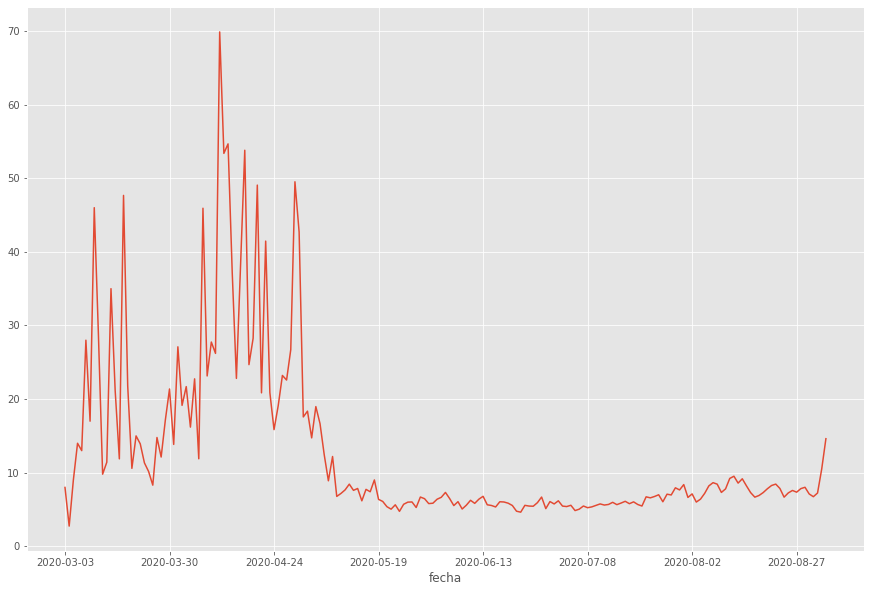

In [40]:
casos_tests[
    casos_tests.residencia_provincia_id == "02"
].set_index(
    "fecha"
).tests_por_confirmado.plot(figsize=(15, 10))

Esta variable puede tener variadas interpretaciones. ¿Qué significa si baja? ¿Se están haciendo los testeos focalizados en zonas con brotes? ¿Se necesitan hacer más tests para estar seguro de que se detecta la cantidad de casos necesarios para localizar los brotes?

Hay muchas interpretaciones posibles, y probablemente requieran de una interpretación más sofisticada. Se lo dejamos a los expertos!

**Ejercicio:** repetir el gráfico para otras provincias y analizar si se comportan de forma similar.